## Cargar librerías

In [1]:
# Cargamos las librerías

import pandas as pd
import openpyxl
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import numpy as np


from matplotlib import pyplot as plt
from matplotlib.ticker import FixedLocator, FixedFormatter
import seaborn as sn

import warnings
warnings.filterwarnings(action="ignore")

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.cluster import KMeans

from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

## Funciones

In [2]:
def correlation_df(df,target,numeric_features,threshold):
    """
    Show the correlation of the df 

 

    Inputs:
    df -- dataframe

 

    Outputs: Charts
    
    Information printed in screen
    """  
    corrmat = df.corr()
    f, ax = plt.subplots(figsize=(15, 15))
    sns.heatmap(corrmat, vmax=.8, square=True)
    
    sns.set(font_scale=0.7)
    plt.figure(figsize=(15, 15))

 

    sns.heatmap(corrmat, vmax=.8, linewidths=0.01,
            square=True,annot=True,cmap='viridis',linecolor="white")
    plt.title('Correlation between features');


def multicorrelation_df(df,target,numeric_features,threshold):
    """
    Show the correlation of the df 

 

    Inputs:
    df -- dataframe

 

    Outputs: Charts
    
    Information printed in screen
    """  

 

    # Plotting correlations
    corrmat = df.corr()

 

    
    important_corrs = (corrmat[abs(corrmat) > threshold][corrmat != 1.0]) \
        .unstack().dropna().to_dict()
        
    unique_important_corrs = pd.DataFrame(list(set([(tuple(sorted(key)), important_corrs[key]) \
    for key in important_corrs])), 
        columns=['Attribute Pair', 'Correlation'])

 

    # sorted by absolute value
    unique_important_corrs = unique_important_corrs.loc[abs(unique_important_corrs['Correlation']).argsort()[::-1]]
    
    return unique_important_corrs

In [3]:
def GetSimilarTeams(TeamName, numTeams, corr_matrix):
    
    SimTeams = pd.DataFrame(columns = ['TeamName', 'Similar Team', 'Correlation Factor'])

    i = 0
    for i in range(0, numTeams):
        row = corr_matrix.loc[corr_matrix.index == TeamName].squeeze()

        SimTeams.at[i, 'TeamName'] = TeamName
        SimTeams.at[i, 'Similar Team'] = row.nlargest(i+2).sort_values(ascending=True).index[0]
        SimTeams.at[i, 'Correlation Factor'] = row.nlargest(i+2).sort_values(ascending=True)[0]

        i = i+1
    
    return SimTeams

In [4]:
def Exec_KMeans(k, X):
    
    kmeans = KMeans(n_clusters=k, random_state=42)
    y_pred = kmeans.fit_predict(X)
    
    print("Centros de los clusters: ", kmeans.cluster_centers_)
    
    plt.figure(figsize=(16, 6))
    cl = ['red', 'green', 'blue', 'yellow', 'black', 'purple']
    assign = []
    for row in y_pred:
        assign.append(cl[row])
        
    plt.scatter(X[:,0], X[:,1], c=assign, s=70)
    
    plt.show()
    
    return y_pred

## Carga de datos

In [5]:
path = r'C:\Users\Miquel\Desktop\Miquel\Estudis\ESTADISTICA\MASTER\BigDataDeportivo\PFM\Datos'

In [6]:
#Teams = pd.read_excel(path + '/players.xlsx', engine = 'openpyxl')
#teams = pd.read_excel(path + '/teamsOK.xlsx', engine = 'openpyxl')
df = pd.read_excel(path + '/teams1.xlsx')

## Preprocesado

In [7]:
df.shape

(98, 35)

Tenemos en nuestro dataset inicial, 98 filas correspondientes a los 98 equipos (20 de la liga española, francesa, inglesa e italiana y 18 de la liga alemana), y 35 variables distintas.

In [8]:
df.head()

,Squad,Poss,Ast,NonPenaltyGoals,npxG+xA,GA,W,D,L,PasesLargosGK%,PasesGK,MediaLongitudPasesGK,#AccionesDefFueraArea,MediaDistAGolAccDef,PasesTotDist,KeyPases,PasesCmp1/3,PasesEnArea,CentrosArea,ShCreatingAct,DefActToSh,GoalCreatingAct,SuccPress%,Mid 3rd Press,Att 3rd Press,Def Pen Touches,Def 3rd Touches,Mid 3rd Touches,Att 3rd Touches,Att Pen Touches,Carries,TotDistCarries,PrgDistCarries,Crosses,BalonesPerdRecup
0,Alavés,42.7,21,30,62.0,57,9,11,18,50.6,795,44.9,23,14.7,221444,245,741,192,75,511,17,54,27.7,2541,1154,2289,6566,8800,3937,640,9827,49054,25070,409,3048
1,Athletic Club,49.8,31,39,72.0,42,11,13,14,44.6,815,38.7,24,14.3,286020,302,1110,298,77,660,13,79,27.6,2380,1376,2111,6458,10859,5688,766,12941,73026,40524,543,3166
2,Atlético Madrid,52.4,54,60,84.7,25,26,8,4,43.4,714,44.6,18,15.3,321009,339,1260,381,61,723,11,117,30.1,2328,1131,2122,7261,12558,6275,992,16070,74449,39926,437,3149
3,Barcelona,65.8,51,76,130.0,38,24,7,7,55.6,1065,29.1,26,16.7,439756,443,1904,551,57,1011,13,125,30.5,2330,1341,2525,7938,15985,10509,1376,23664,113705,63415,411,2895
4,Betis,53.9,35,42,67.7,50,17,10,11,36.1,968,43.0,22,14.5,307041,333,1013,314,83,725,13,81,28.8,2495,1149,2272,7125,11884,6099,879,15486,75005,39374,425,3073


### Revisar tipología de los datos

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98 entries, 0 to 97
Data columns (total 35 columns):
Squad                    98 non-null object
Poss                     98 non-null float64
Ast                      98 non-null int64
NonPenaltyGoals          98 non-null int64
npxG+xA                  98 non-null float64
GA                       98 non-null int64
W                        98 non-null int64
D                        98 non-null int64
L                        98 non-null int64
PasesLargosGK%           98 non-null float64
PasesGK                  98 non-null int64
MediaLongitudPasesGK     98 non-null float64
#AccionesDefFueraArea    98 non-null int64
MediaDistAGolAccDef      98 non-null float64
PasesTotDist             98 non-null int64
KeyPases                 98 non-null int64
PasesCmp1/3              98 non-null int64
PasesEnArea              98 non-null int64
CentrosArea              98 non-null int64
ShCreatingAct            98 non-null int64
DefActToSh               9

Todas las variables parecen tener el tipo de dato adecuado. Solo tenemos una variable que es categórica: el nombre del equipo. El resto de variables son numéricas y se distinguen entre numéricas enteras (integer) y numéricas con decimales (float). Los floats corresponden a variables con porcentajes, medias y esperanzas. Como los xG, xA, % de pases acertado, distancia media de pase del portero, etc. Los demás valores, son valores enteros.

### Veracidad de los datos

In [10]:
df.describe(include = 'object')
df.describe(include = 'int64')
df.describe(include = 'float64')

,Squad
count,98
unique,98
top,Angers
freq,1


,Ast,NonPenaltyGoals,GA,W,D,L,PasesGK,#AccionesDefFueraArea,PasesTotDist,KeyPases,PasesCmp1/3,PasesEnArea,CentrosArea,ShCreatingAct,DefActToSh,GoalCreatingAct,Mid 3rd Press,Att 3rd Press,Def Pen Touches,Def 3rd Touches,Mid 3rd Touches,Att 3rd Touches,Att Pen Touches,Carries,TotDistCarries,PrgDistCarries,Crosses,BalonesPerdRecup
count,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000
mean,35.142857,44.938776,52.234694,13.887755,9.469388,13.887755,987.489796,24.612245,295817.387755,318.806122,1070.122449,295.642857,77.051020,693.489796,16.612245,83.989796,2362.285714,1202.938776,2483.418367,7642.030612,11018.673469,5624.775510,827.459184,14395.551020,74976.142857,40613.010204,439.030612,3156.051020
std,12.534489,14.775862,12.648133,6.162545,2.777688,5.406912,180.528962,10.323262,57134.985858,67.121318,273.134168,86.360936,18.244826,147.807289,5.178530,28.646259,223.246108,168.012507,279.999776,810.432129,1979.698554,1301.331765,207.462587,3055.451357,15457.380901,9232.851997,69.322116,237.785807
min,13.000000,16.000000,23.000000,3.000000,2.000000,3.000000,555.000000,6.000000,178284.000000,189.000000,651.000000,154.000000,30.000000,401.000000,7.000000,25.000000,1897.000000,866.000000,1729.000000,4861.000000,7405.000000,3542.000000,448.000000,8148.000000,43974.000000,23757.000000,245.000000,2711.000000
25%,26.000000,34.000000,44.000000,9.000000,8.000000,10.000000,861.250000,17.000000,261688.000000,270.000000,869.750000,232.750000,63.250000,586.750000,13.000000,61.750000,2214.500000,1083.250000,2287.500000,7138.000000,9599.250000,4685.750000,681.750000,12346.000000,65722.250000,34872.500000,400.000000,2965.750000
50%,33.500000,43.000000,53.000000,12.000000,9.500000,15.000000,988.000000,23.000000,286378.500000,302.000000,1010.500000,272.500000,76.500000,678.500000,17.000000,78.500000,2342.500000,1199.000000,2484.000000,7715.500000,10765.500000,5427.500000,777.500000,13916.000000,74278.000000,39712.500000,437.000000,3123.000000
75%,43.750000,53.750000,58.000000,18.000000,11.000000,18.000000,1088.250000,27.000000,337379.250000,362.500000,1225.750000,355.750000,89.750000,779.500000,19.000000,100.000000,2508.000000,1307.750000,2702.750000,8240.000000,12296.500000,6253.500000,976.500000,16491.500000,85492.750000,47519.000000,489.000000,3273.250000
max,75.000000,89.000000,92.000000,28.000000,16.000000,29.000000,1720.000000,55.000000,442830.000000,480.000000,1904.000000,552.000000,121.000000,1051.000000,35.000000,167.000000,3055.000000,1727.000000,3150.000000,9481.000000,16432.000000,10509.000000,1376.000000,23664.000000,117292.000000,67033.000000,615.000000,4014.000000


,Poss,npxG+xA,PasesLargosGK%,MediaLongitudPasesGK,MediaDistAGolAccDef,SuccPress%
count,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000
mean,50.043878,77.967347,41.821429,38.211224,14.480612,29.528571
std,6.533862,21.179950,6.171722,6.555235,1.415355,1.931774
min,34.300000,42.900000,27.900000,28.500000,11.400000,24.800000
25%,45.100000,63.350000,37.300000,33.425000,13.325000,28.325000
50%,49.750000,72.950000,41.450000,37.600000,14.400000,29.300000
75%,53.975000,87.350000,45.575000,41.100000,15.300000,30.975000
max,65.800000,131.100000,60.900000,57.900000,18.600000,34.300000


Parece que no hay valores máximos o mínimos excesivamente elevados o bajos como para considerarlos demasiado extraños y analizarlos.

#### Comprobamos duplicados

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98 entries, 0 to 97
Data columns (total 35 columns):
Squad                    98 non-null object
Poss                     98 non-null float64
Ast                      98 non-null int64
NonPenaltyGoals          98 non-null int64
npxG+xA                  98 non-null float64
GA                       98 non-null int64
W                        98 non-null int64
D                        98 non-null int64
L                        98 non-null int64
PasesLargosGK%           98 non-null float64
PasesGK                  98 non-null int64
MediaLongitudPasesGK     98 non-null float64
#AccionesDefFueraArea    98 non-null int64
MediaDistAGolAccDef      98 non-null float64
PasesTotDist             98 non-null int64
KeyPases                 98 non-null int64
PasesCmp1/3              98 non-null int64
PasesEnArea              98 non-null int64
CentrosArea              98 non-null int64
ShCreatingAct            98 non-null int64
DefActToSh               9

In [12]:
sum(df.duplicated())

0

Vemos que no hay ningún duplicado. Hay 98 equipos sin duplicados. 

#### Tratamiento de valores nulos

In [13]:
null_columns = df.columns[df.isnull().any()]
null_columns

Index([], dtype='object')

No hay valores nulos

### Multicolinealidad

In [14]:
corrMatrix = df.corr()
corrMatrix.style.background_gradient(cmap='coolwarm').set_precision(3)

,Poss,Ast,NonPenaltyGoals,npxG+xA,GA,W,D,L,PasesLargosGK%,PasesGK,MediaLongitudPasesGK,#AccionesDefFueraArea,MediaDistAGolAccDef,PasesTotDist,KeyPases,PasesCmp1/3,PasesEnArea,CentrosArea,ShCreatingAct,DefActToSh,GoalCreatingAct,SuccPress%,Mid 3rd Press,Att 3rd Press,Def Pen Touches,Def 3rd Touches,Mid 3rd Touches,Att 3rd Touches,Att Pen Touches,Carries,TotDistCarries,PrgDistCarries,Crosses,BalonesPerdRecup
Poss,1,0.707,0.705,0.774,-0.595,0.702,-0.244,-0.676,0.429,0.194,-0.739,0.197,0.377,0.929,0.791,0.882,0.799,0.147,0.793,0.257,0.711,0.608,-0.184,0.552,-0.0341,0.403,0.912,0.819,0.799,0.927,0.891,0.875,0.361,0.0472
Ast,0.707,1,0.966,0.871,-0.553,0.845,-0.312,-0.829,0.453,0.0896,-0.604,0.0747,0.196,0.684,0.786,0.725,0.74,0.168,0.786,0.283,0.963,0.459,-0.174,0.433,-0.107,0.187,0.659,0.678,0.774,0.683,0.685,0.666,0.27,0.0133
NonPenaltyGoals,0.705,0.966,1,0.909,-0.548,0.873,-0.345,-0.821,0.481,0.0603,-0.605,0.0565,0.197,0.714,0.805,0.773,0.771,0.155,0.821,0.347,0.968,0.437,-0.181,0.45,-0.13,0.172,0.692,0.732,0.813,0.723,0.718,0.705,0.267,-0.0133
npxG+xA,0.774,0.871,0.909,1,-0.593,0.838,-0.33,-0.785,0.516,0.0554,-0.65,0.116,0.278,0.778,0.9,0.851,0.88,0.238,0.909,0.357,0.902,0.498,-0.175,0.572,-0.14,0.17,0.749,0.836,0.915,0.788,0.789,0.78,0.409,0.0727
GA,-0.595,-0.553,-0.548,-0.593,1,-0.758,0.106,0.816,-0.285,0.108,0.299,-0.155,-0.288,-0.565,-0.596,-0.655,-0.568,-0.219,-0.585,-0.103,-0.547,-0.404,0.0908,-0.469,0.367,0.0222,-0.578,-0.624,-0.585,-0.561,-0.515,-0.512,-0.434,-0.181
W,0.702,0.845,0.873,0.838,-0.758,1,-0.471,-0.867,0.404,-0.0296,-0.496,0.0611,0.253,0.725,0.794,0.794,0.752,0.147,0.804,0.306,0.868,0.399,-0.113,0.447,-0.182,0.166,0.724,0.755,0.78,0.736,0.705,0.702,0.323,0.0289
D,-0.244,-0.312,-0.345,-0.33,0.106,-0.471,1,0.0461,-0.239,-0.0624,0.243,0.024,-0.0784,-0.281,-0.312,-0.288,-0.313,0.131,-0.305,-0.182,-0.305,-0.12,-0.0426,-0.209,-0.074,-0.182,-0.25,-0.3,-0.333,-0.302,-0.265,-0.257,0.0627,0.0464
L,-0.676,-0.829,-0.821,-0.785,0.816,-0.867,0.0461,1,-0.361,-0.021,0.492,-0.112,-0.272,-0.641,-0.724,-0.708,-0.671,-0.217,-0.726,-0.21,-0.837,-0.504,0.167,-0.404,0.268,-0.0852,-0.642,-0.645,-0.692,-0.638,-0.619,-0.617,-0.314,-0.0657
PasesLargosGK%,0.429,0.453,0.481,0.516,-0.285,0.404,-0.239,-0.361,1,0.19,-0.371,0.117,0.117,0.495,0.486,0.476,0.467,0.371,0.489,0.131,0.476,0.278,-0.205,0.225,0.0338,0.14,0.377,0.402,0.473,0.413,0.413,0.407,0.318,-0.203
PasesGK,0.194,0.0896,0.0603,0.0554,0.108,-0.0296,-0.0624,-0.021,0.19,1,-0.244,0.286,0.263,0.179,0.0405,0.0476,0.0802,-0.0634,0.0085,-0.0966,0.0472,0.194,0.0559,0.129,0.461,0.362,0.0131,-0.0235,0.0755,0.0954,0.12,0.103,-0.121,-0.0239


Desarrollamos un mapa de calor que nos ofrece las correlaciones entre las variables que formarán parte del modelo analítico en primera instancia.
Con esto buscamos identificar aquellas variables que tienen una correlación excesivamente alta entre sí. Para así poder eliminarlas y reducir dimensiones previamente. 
Aunque PCA ya es una técnica que se usa para solventar el problema de la multicolinealidad, nunca está de más echar un vistazo por uno mismo y analizar cuáles tiene sentido o no que acaben entrando en el modelo que usaremos con PCA.

Además del mapa de calor, vamos a calcular el VIF (Variance Inflation Factor), de cada una de las variables. 
VIF es un número que determina si una variable tiene multicolinealidad o no. Ese número también representa cuánto se infla una variable debido a la dependencia lineal con otras variables.

El valor de VIF comienza en 1 y no tiene límite superior. Si el número aumenta, significa que la variable tiene una gran multicolinealidad.
Para calcular el VIF, haremos un proceso de regresión lineal para cada variable, donde esa variable se convertirá en una variable objetivo. Después de hacer ese proceso, calculamos el R cuadrado a partir de él. Y finalmente, calculamos el valor de VIF con esta fórmula:


In [15]:
X = df[list(df.columns[1:])]

vif_info = pd.DataFrame()
vif_info['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_info['Column'] = X.columns
vif_info.sort_values('VIF', ascending=False)

,VIF,Column
29,5205.203732,Carries
30,4965.119808,TotDistCarries
26,3358.388421,Mid 3rd Touches
18,3357.475355,ShCreatingAct
31,3278.795027,PrgDistCarries
14,3150.016014,KeyPases
25,2165.385721,Def 3rd Touches
13,2030.513436,PasesTotDist
33,1404.844353,BalonesPerdRecup
0,1265.838959,Poss


En este caso, nos fijamos en variables que superen una correlación de 0.90 o 0.95, y además tengan un valor VIF muy alto.
Vamos a eliminar variables según su VIF y según las correlaciones con otras variables. Eliminaremos, por ejemplo, los desplazamientos con balón (Carries), tienen un VIF muy elevado, o las acciones que crean un disparo (ShCreatingAction), que se correlacionan casi 1 punto (0.99) con los pases clave (KeyPasses), además de tener un VIF elevado.

Además de ese tipo de variables, también eliminaremos las victories, empates y derrotas (W, D, L). Que a pesar de no correlacionarse elevadamente con ninguna variable ni tener un VIF destacado, las decidimos eliminar por criterios propios, ya que consideramos que lo que cuenta a la hora de encontrar equipos parecidos, es la intención de juego del equipo, y no sus resultados. Así que a nuestro parecer, añadirían un sesgo grave al modelo.

In [16]:
X1 = X.drop(['W', 'D', 'L', 'Carries', 'Mid 3rd Touches', 'ShCreatingAct', 'Def Pen Touches', 'TotDistCarries'], axis = 1)

vif_info = pd.DataFrame()
vif_info['VIF'] = [variance_inflation_factor(X1.values, i) for i in range(X1.shape[1])]
vif_info['Column'] = X1.columns
vif_info.sort_values('VIF', ascending=False)

,VIF,Column
10,963.894840,PasesTotDist
0,872.380984,Poss
9,828.568777,MediaDistAGolAccDef
17,805.568203,SuccPress%
25,728.015164,BalonesPerdRecup
21,647.270897,Att 3rd Touches
22,566.063915,Att Pen Touches
12,537.618075,PasesCmp1/3
20,397.300039,Def 3rd Touches
2,396.076175,NonPenaltyGoals


Hemos conseguido reducir el VIF más alto de 5000 a 900. Pese a que sigue siendo un VIF alto, lo dejaremos así, ya que hemos reducido mucho las variables del dataset inicial y además, como hemos dicho, el PCA ya se encarga de reducir dimensiones.

## PCA

In [17]:
Xcols = list(vif_info.sort_values('VIF', ascending=False)['Column'])

El primer paso que vamos a hacer es pasar todas las métricas como matriz a <strong>X</strong>, y todos los nombres como matriz a <strong>y</strong>. Esto lo hacemos para poder trabajar con las métricas convenientemente, y los nombres los guardamos para trabajar más adelante.

Trabajaremos únicamente con las columnas que hemos decidido no eliminar anteriormente.

In [18]:
#X, y = df.iloc[:, 1:len(df.columns)].values, df.iloc[:, 0].values

X, y = df[Xcols].iloc[:, 0:len(df[Xcols].columns)].values, df.iloc[:, 0].values


Una vez tenemos las dos matrices, debemos escalar los datos para solventar posibles problemas de escalas.

In [19]:
X_std = StandardScaler().fit_transform(X)

A continuación vamos a ejecutar la reducción de dimensionalidad. Lo que queremos hacer es comprimir el dataset hasta un número de dimensiones que no nos haga perder mucha información pero que solucione los problemas que podemos tener. 

Así que no estamos limitados a la hora de escoger el número de componentes finales. Intentaremos coger el número máximo de componentes a partir del cual ya no valga la pena seguir aumentandolo. Para eso visualizaremos en un gráfico, la varianza del modelo que se explica según el número de dimensiones finales del PCA.


In [20]:
pca = PCA(n_components = len(df[Xcols].columns))
pca.fit(X_std)
X_pca = pca.transform(X_std)

PCA(copy=True, iterated_power='auto', n_components=26, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

Ahora que tenemos en <strong>X_pca</strong> la matriz con las dimensiones, vamos a visualizar cuantas dimensiones nos interesan.

Shape x_PCA:  (98, 26)
Explained Variance: 0 components: 0
Explained Variance: 2 components: 0.6059288910317587
Explained Variance: 4 components: 0.7412113442823055
Explained Variance: 6 components: 0.8214177375413322
Explained Variance: 8 components: 0.8849147964868962
Explained Variance: 10 components: 0.9266740856247452
Explained Variance: 12 components: 0.9561555414685614
Explained Variance: 14 components: 0.9743151825702792
Explained Variance: 16 components: 0.9837134267469257
Explained Variance: 18 components: 0.9898714478396364
Explained Variance: 20 components: 0.994257353477603
Explained Variance: 22 components: 0.9971924425711464
Explained Variance: 24 components: 0.99889885221432


Text(0.5,0,'Dimensions')

Text(0,0.5,'Explained Variance')

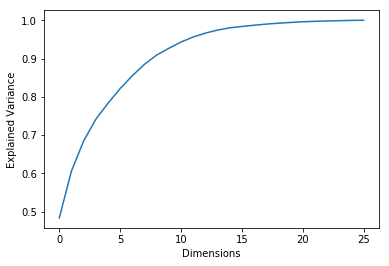

In [21]:
print("Shape x_PCA: ", X_pca.shape)
expl = pca.explained_variance_ratio_

for x in range(0, len(Xcols), 2):
    print("Explained Variance: " + str(x) + " components:", sum(expl[0:x]))

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Dimensions')
plt.ylabel('Explained Variance')
plt.show()

Por los valores que vemos, parece ser que un número ideal de dimensiones podría ser 10. Ya que con 10, llegamos a tener un 90% de la varianza explicada, que es mucho, y nos da una calidad suficiente como para confiar en los resultados salientes. 

In [22]:
N_COMP = 10
columns = []

for col in range(1, N_COMP+1, 1):
    columns.append("PCA" + str(col))

df_pca_resultado = pd.DataFrame(data=X_pca[:,0:N_COMP], columns=columns, index = y)

df_pca_resultado.head()

,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,PCA9,PCA10
Alavés,-4.040409,0.853425,-0.868895,-0.105098,-0.939149,-0.754074,0.487742,1.087530,1.457185,0.938493
Athletic Club,-0.240442,1.210864,-1.757676,0.153622,0.038383,0.932926,0.854802,0.343489,0.496356,0.167334
Atlético Madrid,2.024130,0.271494,-1.146361,-1.443379,-1.793240,1.607824,0.077321,-1.415205,1.097130,0.037879
Barcelona,8.518746,-0.894190,1.102824,0.268379,-1.479732,2.409283,1.131636,0.824883,0.273513,2.057416
Betis,-0.375959,0.337660,-0.362633,-0.143044,-0.014828,0.946340,0.643570,-0.466890,-0.048066,-0.172474


In [23]:
df_pca_resultado.sort_values(by=['PCA1'])

,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,PCA9,PCA10
Cádiz,-6.780202,0.451236,-2.070932,-0.603054,-1.744497,0.333286,-0.334777,0.220488,0.426609,0.064889
Schalke 04,-5.741594,-1.644240,2.991782,-0.381064,-0.804622,1.090394,-1.039961,0.156960,-0.608991,0.800813
West Brom,-5.259828,1.371058,-0.386914,0.400399,-0.968124,0.465472,-0.166143,-0.252004,-1.631012,0.456659
Arminia,-4.466590,0.632165,4.194101,1.612733,-0.743558,-1.061853,1.098020,0.026777,0.404183,0.568574
Newcastle Utd,-4.455217,-1.741197,-1.828486,-1.117337,-0.450018,-0.166610,0.540386,1.070633,-0.749303,-0.696323
Granada,-4.444173,2.022108,0.516151,-0.635136,-2.588960,0.268222,-0.308420,1.243496,-0.215584,-0.946407
Sheffield Utd,-4.442307,2.107072,-0.571131,-0.232933,0.719791,2.269511,2.092488,1.403556,-0.743351,0.759085
Crystal Palace,-4.411949,-0.606419,-0.615053,-1.537225,-0.870057,0.732214,0.316006,0.090354,-0.823166,0.238184
Augsburg,-4.385597,-0.705737,1.708164,-0.101781,-0.731459,-0.382158,-0.850304,-0.395052,0.494859,-0.098662
Dijon,-4.353298,-1.128659,2.030510,0.034929,1.035607,0.961454,-0.287296,0.347032,0.437631,0.414507


Es interesante ver cómo el algoritmo ha juntado las dimensiones, en especial la dimension 1. En la que parece que cobran importancia las variables similares a la posesión, al número de ocasiones de gol creadas, etc. Ya que vemos que los equipos con más puntuación son los equipos más conocidos por su juego ofensivo y de posesión, mientras que los que obtienen menos valor son los que apuestan por un juego más defensivo y de contraataque.

## Clustering

Cómo sabemos, queremos hacer un clustering para visualizar qué equipos son los que se parecen al Betis. Y para hacer un clustering y visualizarlo, necesitaremos solo 2 variables.

Para ello, la solución que se nos ha ocurrido es la siguiente: con los resultados obtenidos del PCA, haremos una mezcla de las componentes, sumando las pares e impares, respectivamente, y juntándolas así en 2 componentes, para poder hacer el clustering.

De otra manera, si hiciéramos PCA con solo 2 componentes principales, tendríamos información poco fiable, ya que la varianza explicada sería solamente del 60%, y eso es bastante pobre.

In [24]:
dfClust = df_pca_resultado
dfClust['V1'] = df_pca_resultado.iloc[:, ::2].sum(axis = 1)
dfClust['V2'] = df_pca_resultado.iloc[:, 1::2].sum(axis = 1)
dfClust = dfClust.drop(dfClust.iloc[:, :10], axis = 1)

Empezamos escalando los datos.

In [25]:
dfClust['V1_std'] = dfClust['V1']
dfClust['V2_std'] = dfClust['V2']

dfClust[['V1_std', 'V2_std']] = StandardScaler().fit_transform(dfClust[['V1', 'V2']])

<Figure size 1152x576 with 0 Axes>

Text(0.5,0,'V1_std')

Text(0,0.5,'V2_std')

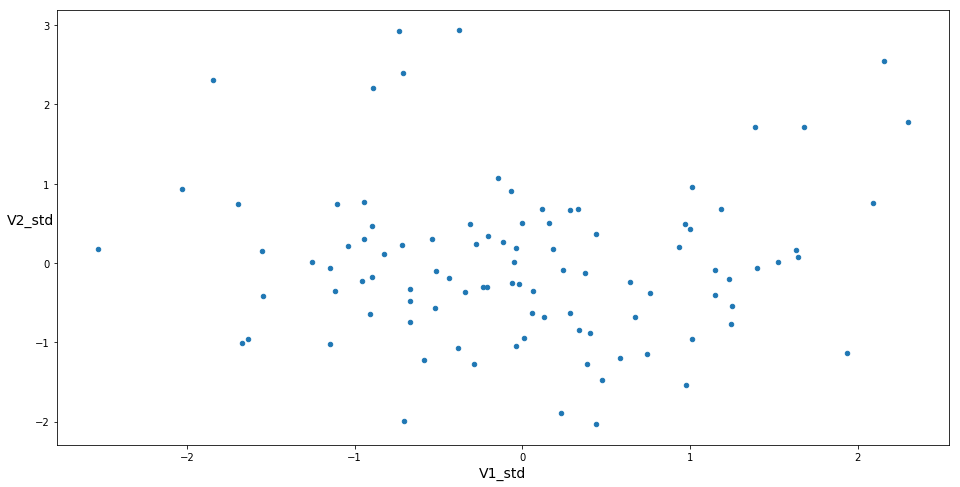

In [26]:
X = dfClust[['V1_std', 'V2_std']].values
plt.figure(figsize=(16, 8))
plt.scatter(X[:, 0], X[:, 1], c=None, s=20)
plt.xlabel("V1_std", fontsize=14)
plt.ylabel("V2_std", fontsize=14, rotation=0)
plt.show()

<Figure size 576x252 with 0 Axes>

Text(0.5,0,'$k$')

Text(0,0.5,'Inertia')

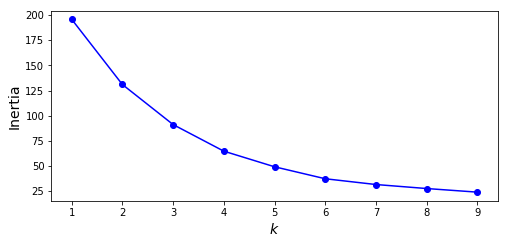

In [27]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X)
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)

plt.show()

El cálculo de la inercia no es una buena forma de medir el número de clusters, porque cuantos más clusters haya menor es la inercia entonces no sabremos donde parar. Pero sí nos dice donde hay un 'codo' o lugar en el que varía susceptiblemente y es un número a tener en cuenta.

En este caso, es difícil ver un ‘codo’ bien marcado, así que vamos a analizar los “silhouette scores”.

<Figure size 576x216 with 0 Axes>

Text(0.5,0,'$k$')

Text(0,0.5,'Silhouette score')

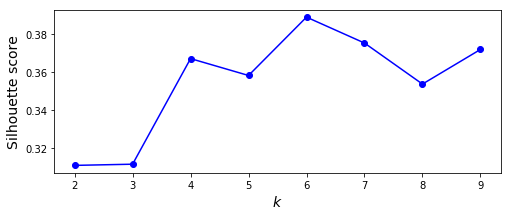

In [28]:
silhouette_scores = [silhouette_score(X, model.labels_) for model in kmeans_per_k[1:]]

plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)

plt.show()

Con este coeficiente podemos entender mejor cual es el número ideal de clusters a seleccionar. Este coeficiente va de +1 a -1, y cuanto más cerca de 1 esté mejor. Cuando está en 1 dice que las muestras tienden a estar bien en su cluster, cuando tiende a 0 dice que las muestras están rozando los bordes de los clusters (como hemos visto en la visualización inicial, que había poca separación) y cuando tiende a -1 dice que las muestras pueden estar asignados erróneamente a un cluster diferente.b

Parece que el número óptimo de clusters es 6, así que probamos con ese número, y quedaría algo así, visualmente:

Centros de los clusters:  [[-1.16389028 -0.08466835]
 [-0.05258251  0.19389965]
 [ 1.92329937  1.70338041]
 [ 1.21579866 -0.04765394]
 [-0.91003481  2.5552892 ]
 [ 0.23647511 -1.17039567]]


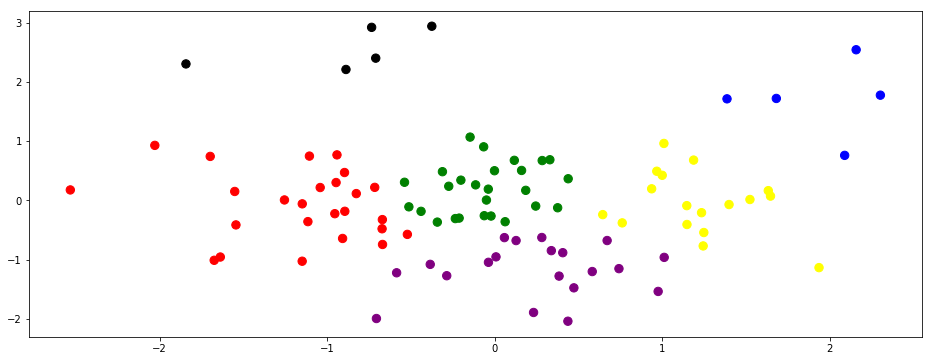

In [29]:
selectedK = 6
dfClust['Cluster'] = Exec_KMeans(selectedK, X)

##### Clusters

In [30]:
dfClust[dfClust['Cluster']==0][['V1', 'V2', 'Cluster']].sort_values(by=['V1', 'V2'], ascending=False)
dfClust[dfClust['Cluster']==1][['V1', 'V2', 'Cluster']].sort_values(by=['V1', 'V2'], ascending=False)
dfClust[dfClust['Cluster']==2][['V1', 'V2', 'Cluster']].sort_values(by=['V1', 'V2'], ascending=False)
dfClust[dfClust['Cluster']==3][['V1', 'V2', 'Cluster']].sort_values(by=['V1', 'V2'], ascending=False)
dfClust[dfClust['Cluster']==4][['V1', 'V2', 'Cluster']].sort_values(by=['V1', 'V2'], ascending=False)
dfClust[dfClust['Cluster']==5][['V1', 'V2', 'Cluster']].sort_values(by=['V1', 'V2'], ascending=False)

,V1,V2,Cluster
Freiburg,-2.161288,-1.502792,0
Torino,-2.775869,-1.949343,0
Wolves,-2.780030,-0.847420,0
Strasbourg,-2.786937,-1.254479,0
Werder Bremen,-2.968712,0.580809,0
Crotone,-3.425714,0.304932,0
Elche,-3.709525,-0.479393,0
Köln,-3.716627,1.238747,0
Augsburg,-3.764337,-1.683390,0
Alavés,-3.903526,2.020275,0


,V1,V2,Cluster
Villarreal,1.819276,0.962882,1
Brest,1.558759,-0.322703,1
Brighton,1.366196,1.804350,1
Spezia,1.176228,1.768834,1
Nîmes,1.015365,-0.247650,1
Arsenal,0.768820,0.449066,1
Real Sociedad,0.665750,1.330262,1
Arminia,0.486156,1.778396,1
Atlético Madrid,0.258980,-0.941386,1
Levante,-0.004775,1.317981,1


,V1,V2,Cluster
Barcelona,9.546987,4.665770,2
Liverpool,8.946915,6.678660,2
Chelsea,8.662804,1.998455,2
RB Leipzig,6.971175,4.520657,2
Rennes,5.750527,4.503593,2


,V1,V2,Cluster
Leeds United,8.028160,-2.975253,3
Monaco,6.827284,0.193783,3
Manchester City,6.772249,0.435419,3
Paris S-G,6.318425,0.043088,3
Atalanta,5.800929,-0.180067,3
Juventus,5.176953,-1.420029,3
Roma,5.160655,-2.014955,3
Real Madrid,5.120625,-0.541297,3
Bayern Munich,4.923562,1.789871,3
Lille,4.759608,-1.064543,3


,V1,V2,Cluster
Getafe,-1.556054,7.720906,4
Sheffield Utd,-2.944509,6.306291,4
Eibar,-3.045744,7.671248,4
Osasuna,-3.681106,5.804716,4
Burnley,-7.641589,6.050412,4


,V1,V2,Cluster
Milan,4.195779,-2.521635,5
Napoli,4.046210,-4.030495,5
Dortmund,3.076005,-3.020604,5
Nice,2.783310,-1.775247,5
Celta Vigo,2.415094,-3.149312,5
Inter,1.960384,-3.871415,5
Tottenham,1.812297,-5.350355,5
Saint-Étienne,1.685201,-2.314058,5
Marseille,1.594218,-3.351071,5
Sampdoria,1.402080,-2.223048,5


In [31]:
list(dfClust[dfClust['Cluster']==1][['V1', 'V2', 'Cluster']].sort_values(by=['V1', 'V2'], ascending=False).index)

['Villarreal',
 'Brest',
 'Brighton',
 'Spezia',
 'Nîmes',
 'Arsenal',
 'Real Sociedad',
 'Arminia',
 'Atlético Madrid',
 'Levante',
 'Bologna',
 'Betis',
 'Huesca',
 'Everton',
 'Fulham',
 'Metz',
 'Athletic Club',
 'Hoffenheim',
 'Hertha BSC',
 'Lens',
 'Dijon',
 'Parma',
 'Reims',
 'Nantes',
 'Cagliari',
 'Aston Villa']

Esta es la lista de equipos parecidos al Real Betis